In [25]:
import warnings
warnings.filterwarnings('ignore')
import FateAxis.tool.main_function as fa
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import FateAxis.tool.extractor as ext
import cospar as cs
from scipy.stats import rankdata
import FateAxis.tool.preprocessor as pp

In [73]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [2]:
### get data from this cospar package
adata_orig = sc.read_h5ad('/data/jiangjunyao/public/cospar data/CellTagging_adata_preprocessed.h5ad')
adata_orig = cs.pp.initialize_adata_object(adata_orig)
cs.hf.update_time_ordering(
    adata_orig, updated_ordering=["Day6", "Day9", "Day12", "Day15", "Day21", "Day28"]
)

Time points with clonal info: ['Day12' 'Day15' 'Day21' 'Day28' 'Day6' 'Day9']


In [16]:
adata_used = adata_orig[adata_orig.obs["Reference_fate_bias"]!=0.5]

In [74]:
adata_used

AnnData object with n_obs × n_vars = 2860 × 28001
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'

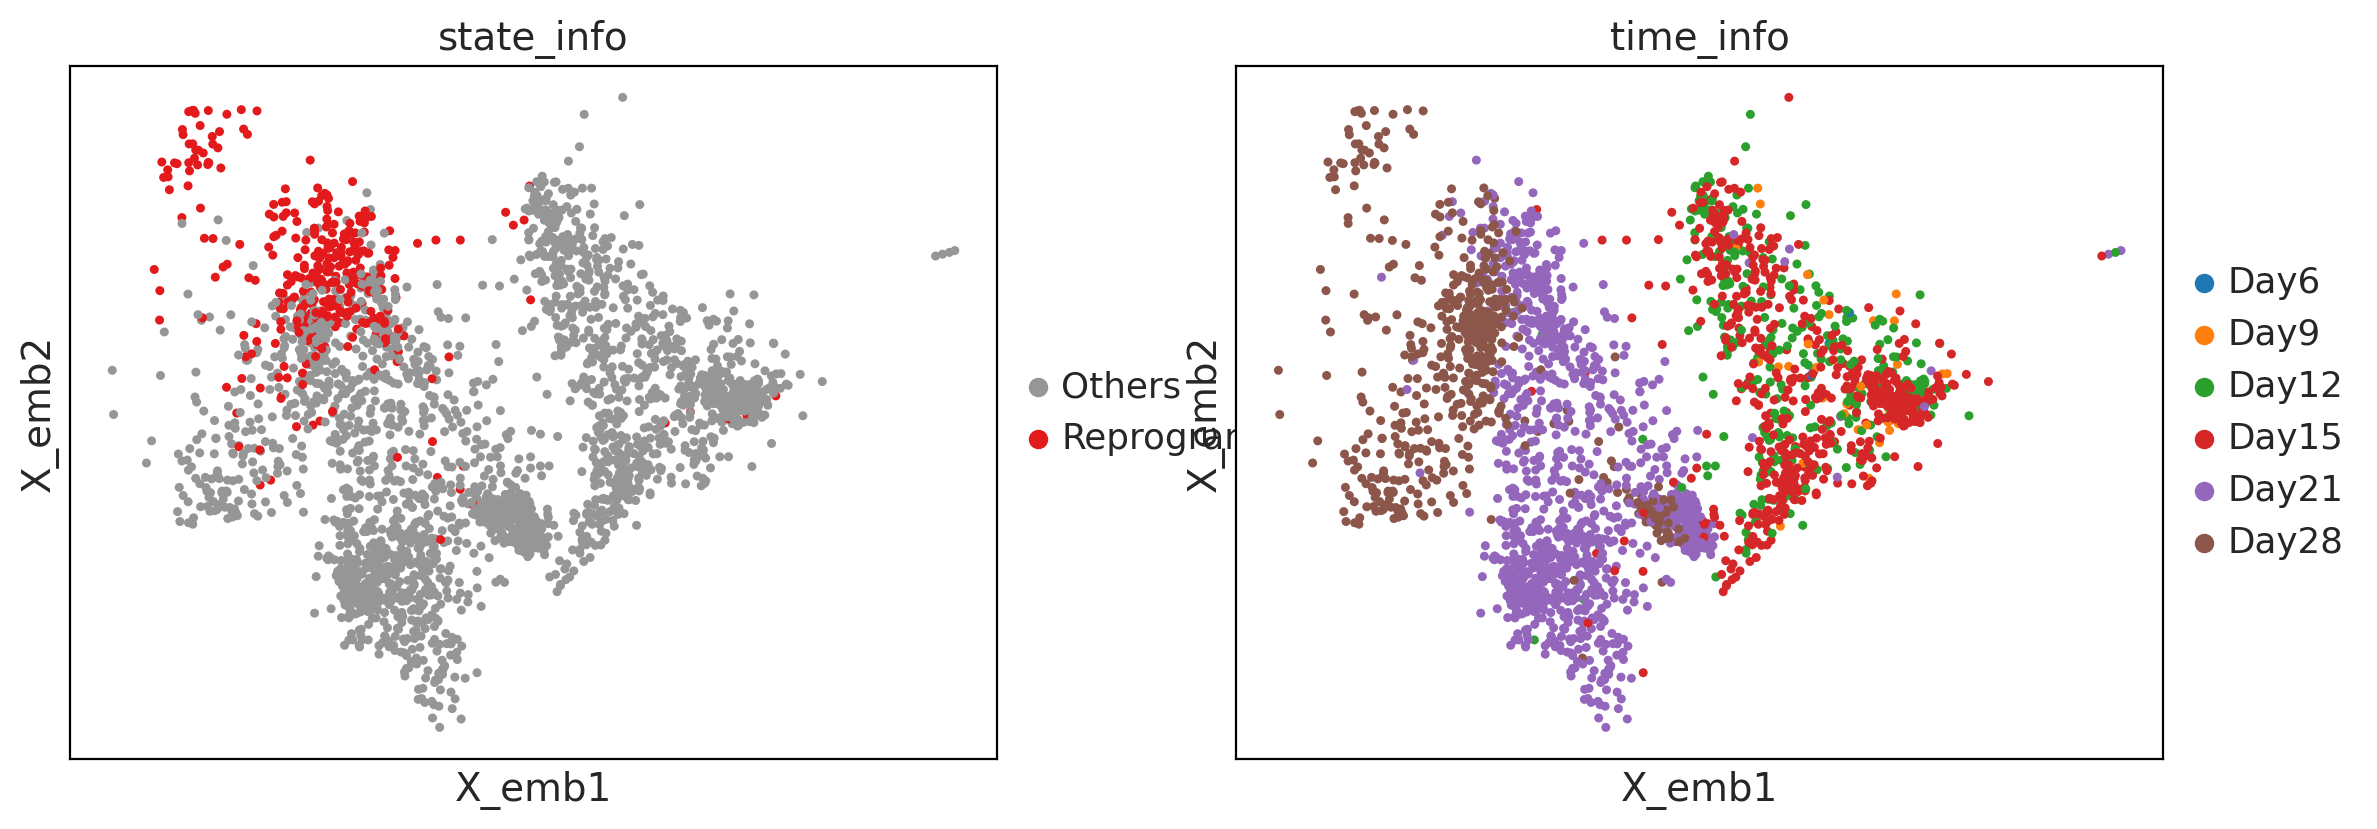

In [75]:
### Task1: identify key factor that regulate 'Others' (Day 6,9,12,15,21,28) reprogramming to reprogrammed cells (Day28)
sc.pl.embedding(adata_used, color=['state_info','time_info'],basis='X_emb')

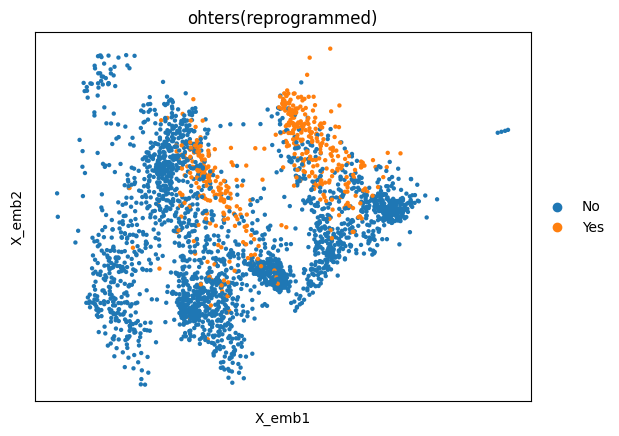

In [24]:
### Task2: based on TFs identified above, further identify which subcluster of 'Others' will reprogramme to reprogrammed cells
### Here is the ground truth
if 'Reference_fate_bias' in adata_used.obs.columns and 'state_info' in adata_used.obs.columns:
    adata_used.obs['ohters(reprogrammed)'] = 'No'  # 默认值为 'No'
    condition = (adata_used.obs['Reference_fate_bias'] == 1) & (adata_used.obs['state_info'] == 'Others') & (adata_used.obs['time_info'] != 'Day28')
    adata_used.obs.loc[condition, 'ohters(reprogrammed)'] = 'Yes'
sc.pl.embedding(adata_used, color=['ohters(reprogrammed)'],basis='X_emb')

In [31]:
adata_used.obs.state_info.value_counts()

Others          2506
Reprogrammed     354
Failed           171
Name: state_info, dtype: int64

In [38]:
adata_used.obsm['X_umap'] = adata_used.obsm['X_emb']

In [39]:
### let's make a baseline
### preprocess metacell grn
import celloracle as co
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
adata_used = adata_used[adata_used.obs.state_info.isin(['Others','Reprogrammed'])]
processor=pp.pper(adata_used, baseGRN=base_GRN,group='state_info',species='mm',ncores=10)
processor.extract_fea(tf_exp_thr=0.025,type='hvg')
processor.construct_full_grn()
processor.construct_metacell_grn(cell_number=50,metacell_num=50)
grp_mt = processor.filter_grp(processor.meta_grn)

sig deg num:2000
expressed tf num:664
total feature num:2576
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/2226 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/2226 [00:00<?, ?it/s]

celltype Others. raw pair 374464 filter pair 147571
celltype Reprogrammed. raw pair 374464 filter pair 130177
0
AnnData object with n_obs × n_vars = 100 × 1800
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1640 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1640 [00:00<?, ?it/s]

1
AnnData object with n_obs × n_vars = 100 × 1787
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1630 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1630 [00:00<?, ?it/s]

2
AnnData object with n_obs × n_vars = 100 × 1817
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1653 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1653 [00:00<?, ?it/s]

3
AnnData object with n_obs × n_vars = 100 × 1806
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1644 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1644 [00:00<?, ?it/s]

4
AnnData object with n_obs × n_vars = 100 × 1808
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1646 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1646 [00:00<?, ?it/s]

5
AnnData object with n_obs × n_vars = 100 × 1823
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1654 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1654 [00:00<?, ?it/s]

6
AnnData object with n_obs × n_vars = 100 × 1786
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1629 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1629 [00:00<?, ?it/s]

7
AnnData object with n_obs × n_vars = 100 × 1807
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1647 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1647 [00:00<?, ?it/s]

8
AnnData object with n_obs × n_vars = 100 × 1820
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1657 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1657 [00:00<?, ?it/s]

9
AnnData object with n_obs × n_vars = 100 × 1788
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1625 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1625 [00:00<?, ?it/s]

10
AnnData object with n_obs × n_vars = 100 × 1812
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1647 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1647 [00:00<?, ?it/s]

11
AnnData object with n_obs × n_vars = 100 × 1767
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1610 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1610 [00:00<?, ?it/s]

12
AnnData object with n_obs × n_vars = 100 × 1830
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1661 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1661 [00:00<?, ?it/s]

13
AnnData object with n_obs × n_vars = 100 × 1785
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1627 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1627 [00:00<?, ?it/s]

14
AnnData object with n_obs × n_vars = 100 × 1832
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1664 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1664 [00:00<?, ?it/s]

15
AnnData object with n_obs × n_vars = 100 × 1810
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1646 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1646 [00:00<?, ?it/s]

16
AnnData object with n_obs × n_vars = 100 × 1810
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1647 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1647 [00:00<?, ?it/s]

17
AnnData object with n_obs × n_vars = 100 × 1811
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1646 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1646 [00:00<?, ?it/s]

18
AnnData object with n_obs × n_vars = 100 × 1821
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1656 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1656 [00:00<?, ?it/s]

19
AnnData object with n_obs × n_vars = 100 × 1812
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1653 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1653 [00:00<?, ?it/s]

20
AnnData object with n_obs × n_vars = 100 × 1804
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1643 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1643 [00:00<?, ?it/s]

21
AnnData object with n_obs × n_vars = 100 × 1795
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1632 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1632 [00:00<?, ?it/s]

22
AnnData object with n_obs × n_vars = 100 × 1802
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1639 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1639 [00:00<?, ?it/s]

23
AnnData object with n_obs × n_vars = 100 × 1800
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1640 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1640 [00:00<?, ?it/s]

24
AnnData object with n_obs × n_vars = 100 × 1807
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1651 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1651 [00:00<?, ?it/s]

25
AnnData object with n_obs × n_vars = 100 × 1835
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1671 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1671 [00:00<?, ?it/s]

26
AnnData object with n_obs × n_vars = 100 × 1805
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1643 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1643 [00:00<?, ?it/s]

27
AnnData object with n_obs × n_vars = 100 × 1818
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1655 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1655 [00:00<?, ?it/s]

28
AnnData object with n_obs × n_vars = 100 × 1824
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1653 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1653 [00:00<?, ?it/s]

29
AnnData object with n_obs × n_vars = 100 × 1800
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1639 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1639 [00:00<?, ?it/s]

30
AnnData object with n_obs × n_vars = 100 × 1817
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1653 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1653 [00:00<?, ?it/s]

31
AnnData object with n_obs × n_vars = 100 × 1791
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1626 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1626 [00:00<?, ?it/s]

32
AnnData object with n_obs × n_vars = 100 × 1790
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1629 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1629 [00:00<?, ?it/s]

33
AnnData object with n_obs × n_vars = 100 × 1804
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1641 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1641 [00:00<?, ?it/s]

34
AnnData object with n_obs × n_vars = 100 × 1785
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1627 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1627 [00:00<?, ?it/s]

35
AnnData object with n_obs × n_vars = 100 × 1790
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1628 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1628 [00:00<?, ?it/s]

36
AnnData object with n_obs × n_vars = 100 × 1809
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1648 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1648 [00:00<?, ?it/s]

37
AnnData object with n_obs × n_vars = 100 × 1811
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1646 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1646 [00:00<?, ?it/s]

38
AnnData object with n_obs × n_vars = 100 × 1803
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1637 [00:00<?, ?it/s]

39
AnnData object with n_obs × n_vars = 100 × 1826
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1657 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1657 [00:00<?, ?it/s]

40
AnnData object with n_obs × n_vars = 100 × 1793
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1633 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1633 [00:00<?, ?it/s]

41
AnnData object with n_obs × n_vars = 100 × 1782
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1622 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1622 [00:00<?, ?it/s]

42
AnnData object with n_obs × n_vars = 100 × 1796
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1632 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1632 [00:00<?, ?it/s]

43
AnnData object with n_obs × n_vars = 100 × 1809
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1646 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1646 [00:00<?, ?it/s]

44
AnnData object with n_obs × n_vars = 100 × 1826
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1668 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1668 [00:00<?, ?it/s]

45
AnnData object with n_obs × n_vars = 100 × 1786
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1626 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1626 [00:00<?, ?it/s]

46
AnnData object with n_obs × n_vars = 100 × 1809
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1650 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1650 [00:00<?, ?it/s]

47
AnnData object with n_obs × n_vars = 100 × 1818
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1653 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1653 [00:00<?, ?it/s]

48
AnnData object with n_obs × n_vars = 100 × 1819
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1649 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1649 [00:00<?, ?it/s]

49
AnnData object with n_obs × n_vars = 100 × 1804
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias', 'barcode_day0', 'barcode_day3', 'barcode_day13', 'barcode_all', 'ohters(reprogrammed)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'clonal_time_points', 'clone_id', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering', 'ohters(reprogrammed)_colors', 'hvg'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_D0', 'X_clone_D13', 'X_clone_D3', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca', 'X_umap'
build grn based on celloracle


  0%|          | 0/2 [00:00<?, ?it/s]

Inferring GRN for Others...


  0%|          | 0/1639 [00:00<?, ?it/s]

Inferring GRN for Reprogrammed...


  0%|          | 0/1639 [00:00<?, ?it/s]

In [40]:
### here is the metacell grn
grp_mt

,0#Others,0#Reprogrammed,1#Others,1#Reprogrammed,2#Others,2#Reprogrammed,3#Others,3#Reprogrammed,4#Others,4#Reprogrammed,...,45#Others,45#Reprogrammed,46#Others,46#Reprogrammed,47#Others,47#Reprogrammed,48#Others,48#Reprogrammed,49#Others,49#Reprogrammed
E2f1#Slc7a11,0.017895,0.000000,-0.003109,0.000000,0.000000,0.000000,0.001514,0.000000,0.001439,0.000000,...,0.012509,0.000000,0.002126,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rest#Wnt10a,0.002618,0.000000,0.000000,0.000000,0.000000,0.000000,0.005108,0.000000,-0.019091,0.000000,...,-0.021605,0.000000,-0.005029,0.000000,0.000000,0.000000,-0.007262,0.000000,0.000000,0.000000
Srf#Runx1,-0.006096,-0.005203,-0.005852,0.007103,-0.016526,0.019008,0.000000,0.007591,-0.012277,-0.003659,...,0.013648,0.000000,0.000000,0.003963,-0.007986,0.002349,0.004631,-0.007038,-0.003781,0.009625
Thra#Prss23,0.006025,0.000000,0.000000,0.000000,0.008413,-0.005356,0.008393,0.003363,-0.005831,-0.003665,...,0.016143,0.002492,0.000000,0.011579,0.000000,-0.002933,0.009416,0.006624,0.007890,0.004182
Tcf12#Sod3,0.000000,-0.034177,0.000000,0.000000,0.017776,-0.033640,0.038315,-0.022094,-0.010867,-0.042949,...,-0.023032,-0.035228,-0.028892,-0.032463,-0.036215,-0.021091,0.058489,-0.030485,0.000000,-0.016322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fosb#Mafk,0.000000,0.000000,0.008346,0.006374,-0.003388,0.000000,0.000000,0.003424,0.001126,-0.004862,...,-0.003433,-0.004702,0.005514,-0.005180,0.000000,0.000000,0.000000,0.006806,0.001821,-0.012316
Nr2f2#Anln,-0.006723,0.000000,0.005267,0.000000,-0.003187,0.006010,-0.004628,0.007764,-0.002529,0.004320,...,0.000000,-0.003208,0.005161,0.006475,0.005579,0.003103,0.000000,0.000000,-0.020101,0.001907
Taf1#Trim28,0.000000,0.009495,0.000000,-0.012772,0.000000,0.013494,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.007024,0.000000,-0.003155,0.000000,0.014634,0.000000,0.008790,0.000000,0.003220
Sin3a#P4ha2,0.000000,0.013861,0.000000,0.000000,0.000000,0.000000,0.000000,0.015716,0.000000,0.008924,...,0.000000,-0.004942,0.000000,0.011605,0.000000,0.000000,0.000000,0.004794,0.000000,0.008430


In [42]:
### wilcox test to filter grn
data = grp_mt.abs()
label = [0 if 'Others' in s else 1 for s in list(data.columns)]
filter_data = fa.filter_grp_mt(data,label,absFC_cutoff=1.25)

In [45]:
### classification and explanation
config_path = '/data/jiangjunyao/FateAxis/FateAxis/config/config1.js'
filter_data = sc.AnnData(filter_data.T,)
fsn,model_ext,outline_df = fa.calculate_grp_importance(filter_data,label,config_path,['cnn','gru','gbm','rf','svm','lgr'],
                                                       max_loop_number=10,core_use=20,outlier_quantile=75,drop_rate=0.1,device='cuda:0')
tf_importance = fa.cal_tf_score(outline_df)

Classify grp at iteration: 1
drop number:13642
outlier number:2000
View of AnnData object with n_obs × n_vars = 100 × 120785
Classify grp at iteration: 2
drop number:12078
outlier number:2375
View of AnnData object with n_obs × n_vars = 100 × 106332
Classify grp at iteration: 3
drop number:10633
outlier number:1399
View of AnnData object with n_obs × n_vars = 100 × 94300
Classify grp at iteration: 4
drop number:9430
outlier number:729
View of AnnData object with n_obs × n_vars = 100 × 84141
Classify grp at iteration: 5
drop number:8414
outlier number:369
View of AnnData object with n_obs × n_vars = 100 × 75358
Classify grp at iteration: 6
drop number:7535
outlier number:237
View of AnnData object with n_obs × n_vars = 100 × 67586
Classify grp at iteration: 7
drop number:6758
outlier number:144
View of AnnData object with n_obs × n_vars = 100 × 60684
Classify grp at iteration: 8
drop number:6068
outlier number:77
View of AnnData object with n_obs × n_vars = 100 × 54539
Classify grp at i

In [95]:
outline_df

,outline_fea,outline_score,outline_ite,outline_percent,Source,Target,weight,grp_score
0,Trp53#Col3a1,43.753141,1,0.504217,Trp53,Col3a1,0.504217,22.061094
1,Sp2#Col3a1,35.391113,1,0.504217,Sp2,Col3a1,0.504217,17.844814
2,Nfil3#Col3a1,33.313459,1,0.504217,Nfil3,Col3a1,0.504217,16.797225
3,Ctcf#Apoa1,31.183303,1,0.504217,Ctcf,Apoa1,0.504217,15.723163
4,Zbtb18#Col3a1,30.446785,1,0.504217,Zbtb18,Col3a1,0.504217,15.351798
...,...,...,...,...,...,...,...,...
7388,Hoxc5#Mif,3.007361,10,0.001116,Hoxc5,Mif,0.000482,0.001451
7389,Meis1#Sdc4,3.005820,10,0.001116,Meis1,Sdc4,0.000482,0.001450
7390,Hoxa5#Sdc4,3.002151,10,0.001116,Hoxa5,Sdc4,0.000482,0.001448
7391,Snai2#Dbi,3.001476,10,0.001116,Snai2,Dbi,0.000482,0.001448


In [48]:
tf_importance

,TF,Score
0,Stat3,76.230788
1,Sp1,74.157572
2,Egr1,74.015058
3,Ctcf,66.876234
4,Zbtb7a,63.920118
...,...,...
379,Hbp1,0.010941
380,Hltf,0.010775
381,Zfp784,0.008960
382,Eomes,0.008187


In [91]:
TF_list = tf_importance[tf_importance['Score']>30]['TF'].tolist()

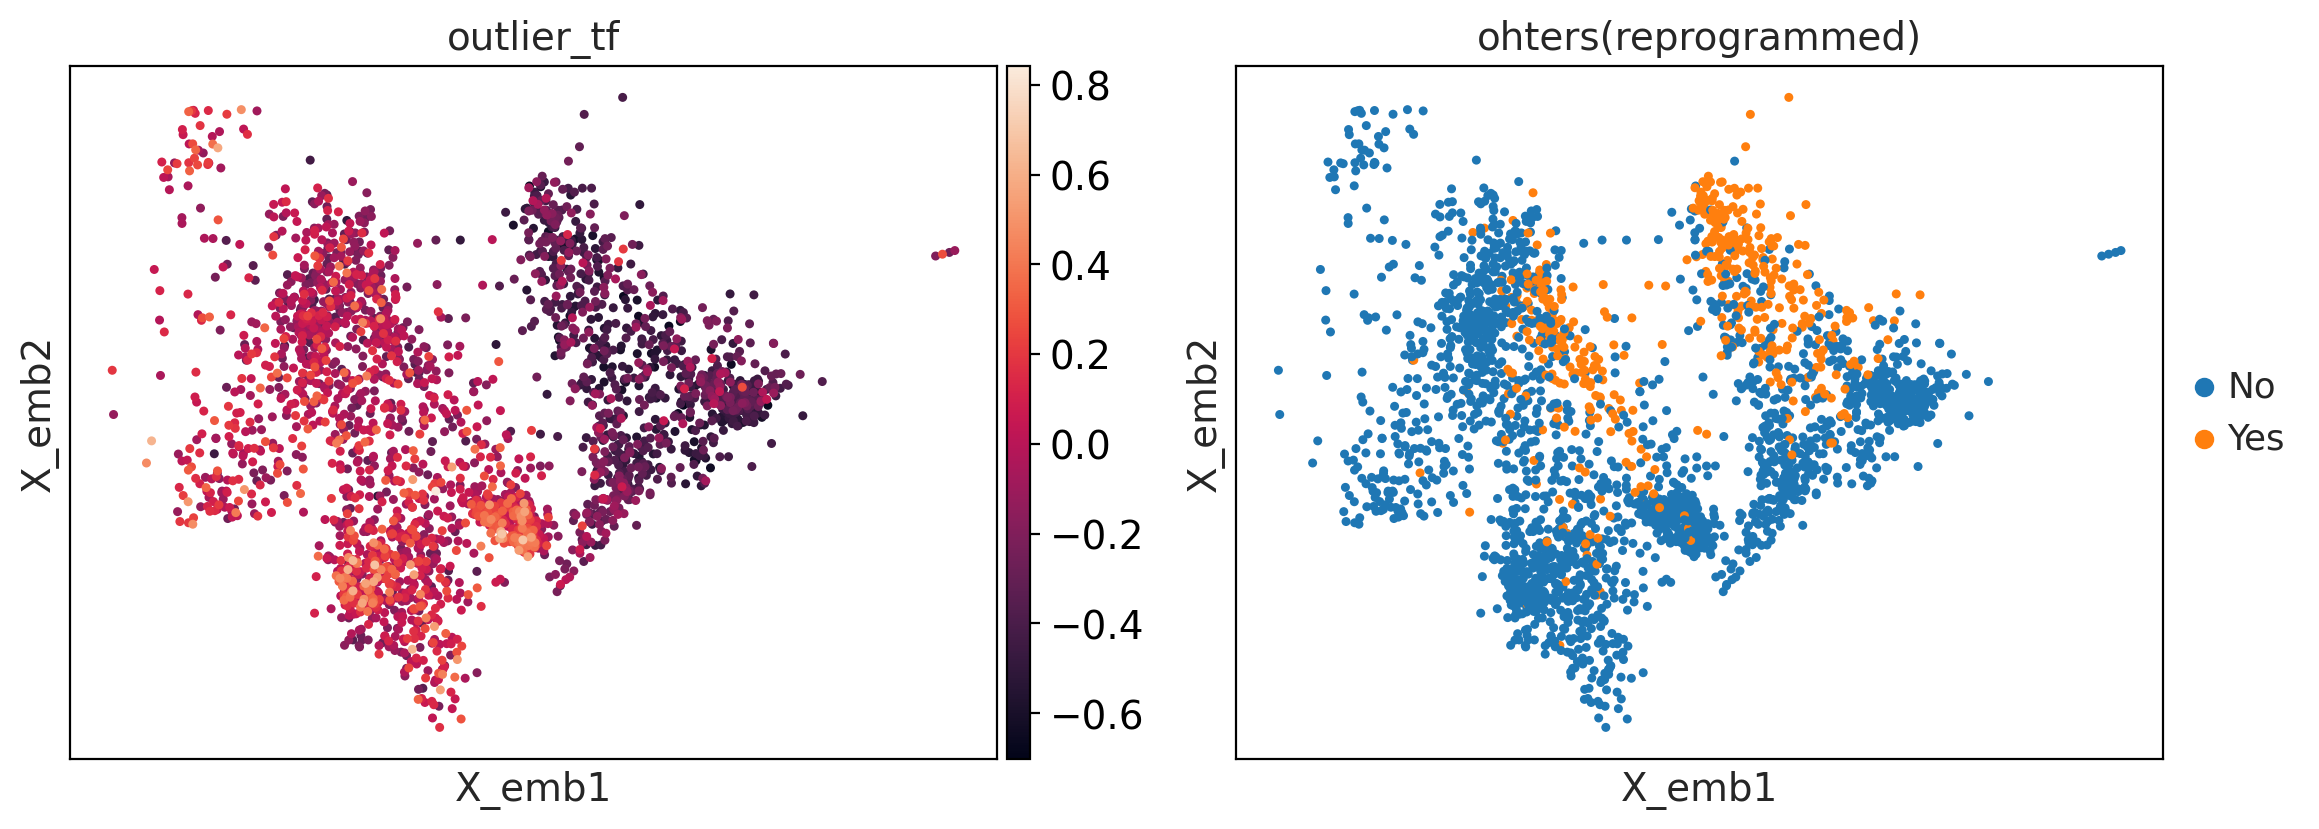

In [94]:
### Then, use high ranked Tfs to cal cell score to try to identify which subcluster of 'Others' will reprogramme to reprogrammed cells
### result is yi tuo da bian
sc.tl.score_genes(adata_used,TF_list,score_name='outlier_tf')
sc.pl.embedding(adata_used, color=['outlier_tf','ohters(reprogrammed)'],basis='X_emb')

In [108]:
### Then we calculate TF activity for each cell (same as scenic)
### and, try to identify subcluster of 'Others' based on TF activity
regulons = outline_df.groupby('Source')['Target'].apply(list).to_dict()

def calculate_auc(adata, regulons):

    expression_data = pd.DataFrame(adata_used.X.toarray(), index=list(adata.obs.index), columns=list(adata.var.index))
    auc_scores = pd.DataFrame(index=expression_data.index, columns=regulons.keys())
    
    for cell in expression_data.index:

        gene_expression = expression_data.loc[cell]
        gene_ranks = rankdata(-gene_expression, method='max')
        
        for tf, target_genes in regulons.items():

            target_ranks = [gene_ranks[expression_data.columns.get_loc(gene)] for gene in target_genes if gene in expression_data.columns]

            if len(target_ranks) > 0:
                n_total = len(gene_expression)
                n_target = len(target_ranks)
                target_ranks.sort()
                
                auc = (sum(target_ranks) - (n_target * (n_target + 1) / 2)) / (n_target * (n_total - n_target))
                auc_scores.at[cell, tf] = auc

            else:
                auc_scores.at[cell, tf] = np.nan

    return auc_scores

auc_scores = calculate_auc(adata_used, regulons)
print(auc_scores)

            Ahr      Alx1    Arid3a    Arid3b    Arid5b      Arnt     Arnt2  \
52     0.472946  0.736372  0.603329       1.0  0.010607  0.397929   0.27729   
59      0.18872  0.635095  0.259308  0.218464  0.006893  0.275365  0.662523   
61     0.272124    0.5965  0.414874     0.137  0.010179  0.253284  0.513073   
63     0.360475  0.751748  0.420174  0.130929  0.019357  0.429383  0.618131   
67     0.227908  0.591918  0.454772  0.131857  0.216714  0.212645  0.306872   
...         ...       ...       ...       ...       ...       ...       ...   
18773  0.256455  0.482981  0.428161  0.007143    0.0185  0.330312  0.448586   
18776  0.361608  0.729151  0.426254  0.051857  0.027607  0.294992  0.803465   
18778  0.204277  0.467682  0.245435  0.089107  0.032464  0.246623  0.064745   
18797  0.256094  0.729886   0.62824       1.0       1.0   0.40407  0.614688   
18799  0.416531  0.588738  0.624511  0.012607   0.04125  0.535561  0.452186   

          Arntl    Arntl2      Atf1  ...    Zfp524 

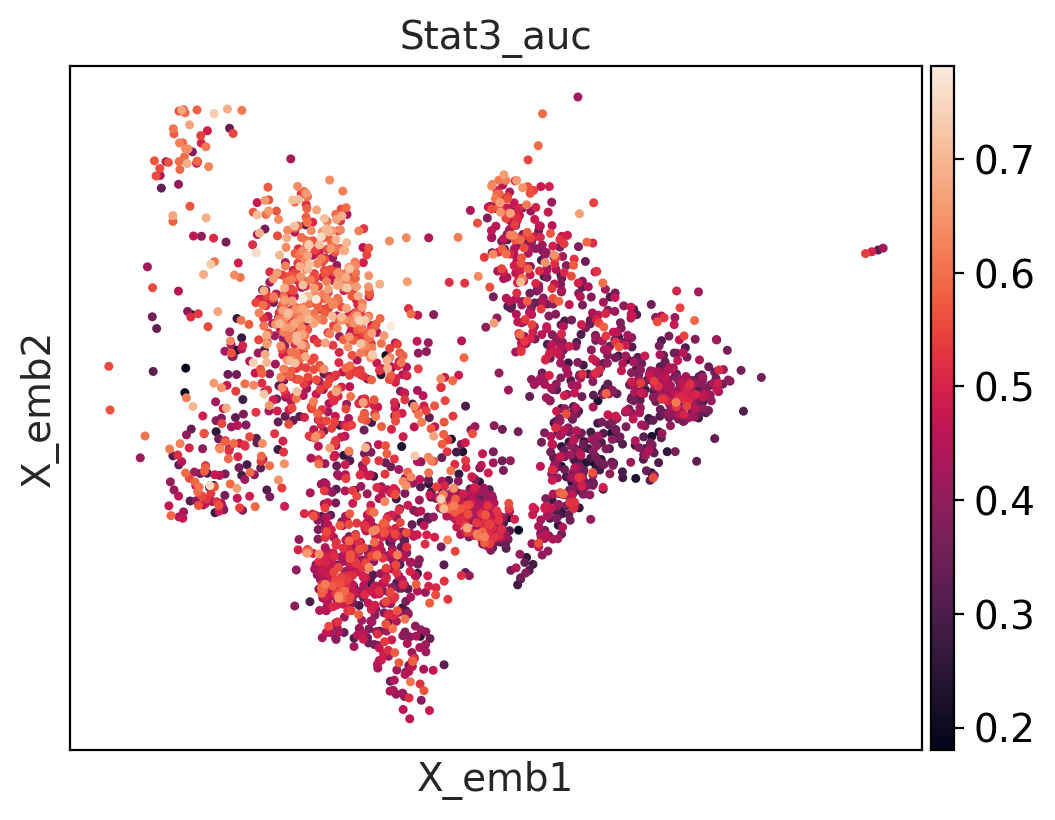

In [110]:
### Try single tf activity
adata_used.obs['Stat3_auc'] = auc_scores['Stat3']
sc.pl.embedding(adata_used, color=['Stat3_auc'],basis='X_emb')

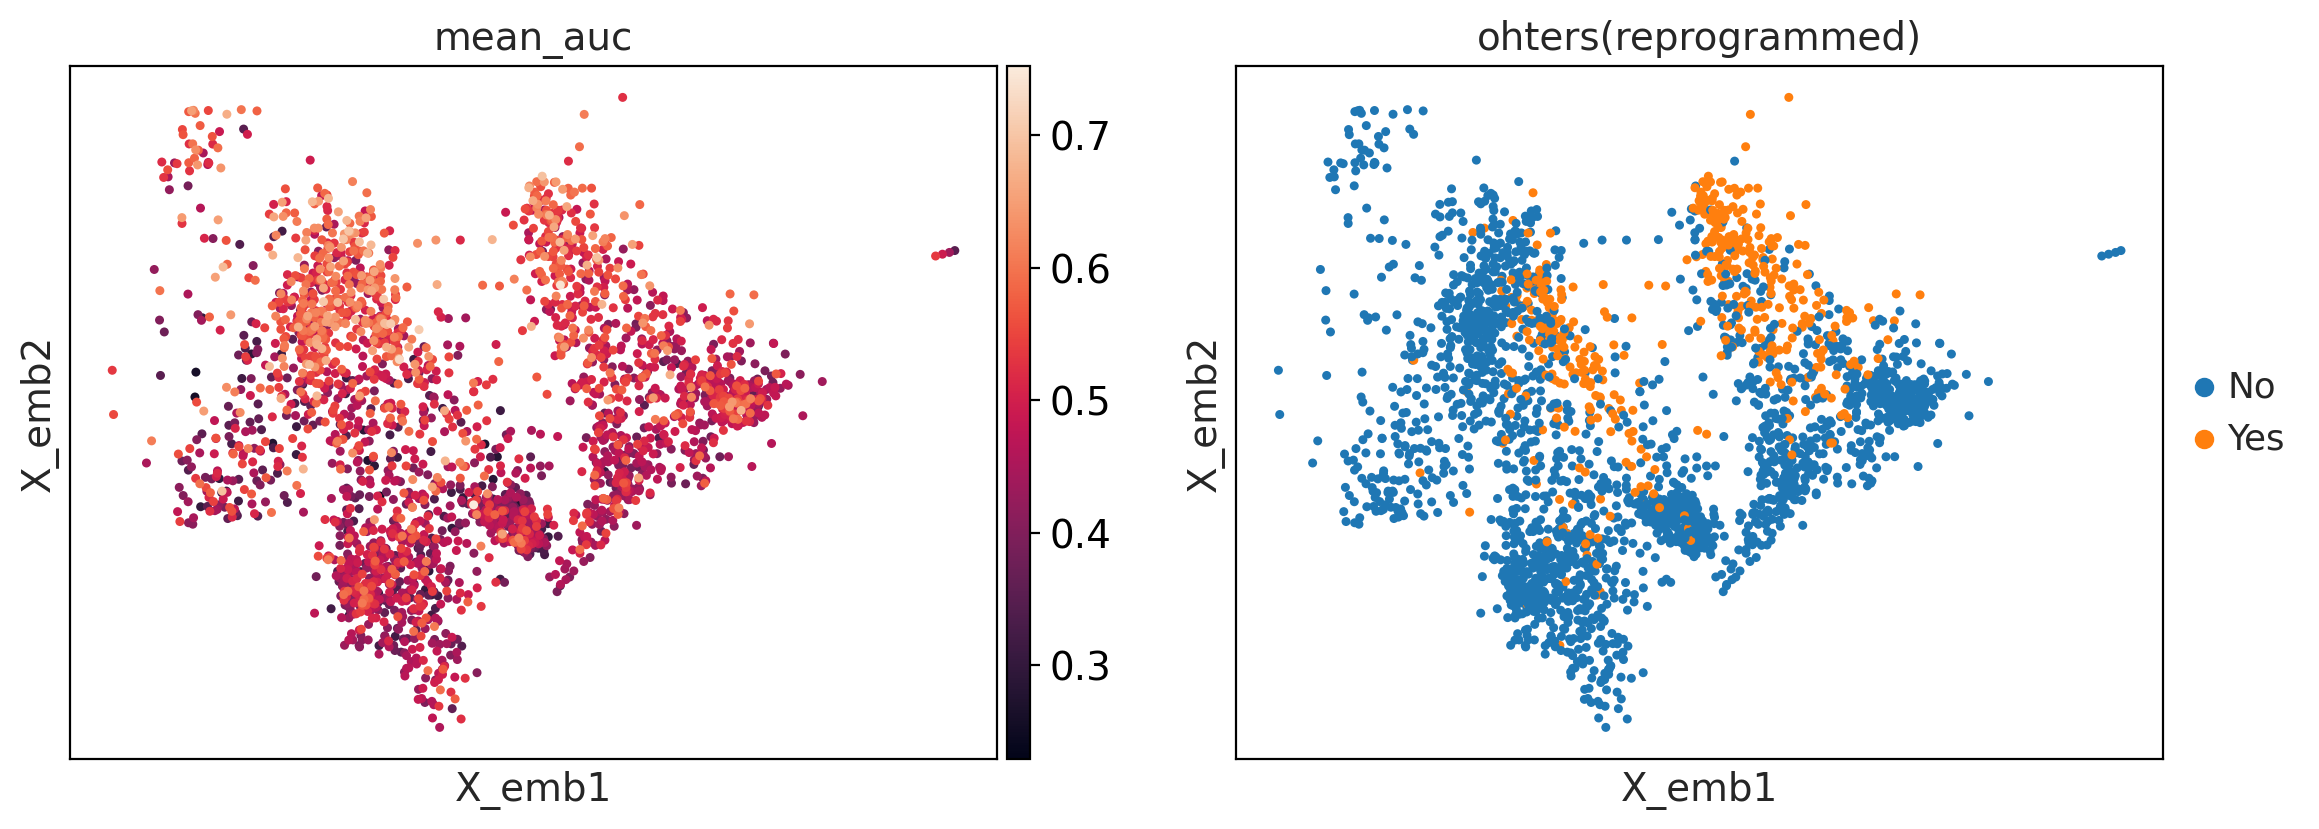

In [113]:
### Then calculate mean auc based on top TF
interested_auc_scores = auc_scores[TF_list]
mean_auc_scores = interested_auc_scores.mean(axis=1)
adata_used.obs['mean_auc'] = mean_auc_scores
### woo! this result looks better!
sc.pl.embedding(adata_used, color=['mean_auc','ohters(reprogrammed)'],basis='X_emb')